# Bayesian Network Concepts
In this notebook, we will review some concepts about conditional probability tables, how to estimate them and how to use them. We will do this using the [pgmpy python suite](https://pgmpy.org/index.html). We will first import the set the paths and import pgmpy into the Jupyter environment. 

In [52]:
import pgmpy

## Step 1. Create a small dataset 
This example is a toy example with just four variables. The are `fruit`, `tasty`, `size`, `color`. We will use the python `pandas` to create this dataset. This dataset has 14 samples.  

In [53]:
import pandas as pd
data = pd.DataFrame(data={'fruit': ["banana", "apple", "banana", "apple", "banana","apple", "banana",
                                    "apple", "apple", "apple", "banana", "banana", "apple", "banana",],
                          'tasty': ["yes", "no", "yes", "yes", "yes", "yes", "yes",
                                    "yes", "yes", "yes", "yes", "no", "no", "no"],
                          'size': ["large", "large", "large", "small", "large", "large", "large",
                                    "small", "large", "large", "large", "large", "small", "small"],
                         'color': ["yellow","green","yellow","red","green","red","yellow",
                                  "red","yellow","green","green","yellow","red","green"]})



Let's look at our data by printing it out. Using this dataset, we will try to answer simple questions like the probability of a banana being tasty given its size.  

In [54]:
print(data)

     fruit tasty   size   color
0   banana   yes  large  yellow
1    apple    no  large   green
2   banana   yes  large  yellow
3    apple   yes  small     red
4   banana   yes  large   green
5    apple   yes  large     red
6   banana   yes  large  yellow
7    apple   yes  small     red
8    apple   yes  large  yellow
9    apple   yes  large   green
10  banana   yes  large   green
11  banana    no  large  yellow
12   apple    no  small     red
13  banana    no  small   green


## Step 2. Create a Bayesian network
We will now create a Bayesian Network for our dataset. We will assume that the network will have `fruit` as the parent of `size` and `color` and, these two will determine if the fruit is tasty! We will use the `BayesianNetwork` class from pgmpy.

In [55]:
from pgmpy.models import BayesianNetwork

Specify the structure of the Bayesian network by adding edges from parent to child.

In [56]:
model=BayesianNetwork([('fruit','size'),('fruit','color'),('size', 'tasty'), ('color', 'tasty')])

Let's draw out the structure of the Bayesian network. We will use the `networkx` package for this.

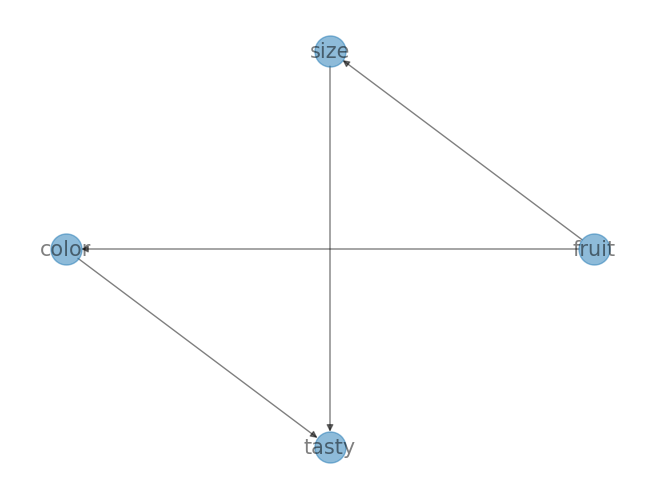

In [57]:
import importlib
import networkx as nx
import matplotlib.pyplot as plt
pos=nx.circular_layout(model)
#pos=nx.spring_layout(model)
#pos=nx.planar_layout(model)
nx.draw(model,pos=pos,with_labels=True,node_size=500,font_size=15,alpha=0.5);
plt.show()

## Step 3. Parameter estimation of the Bayesian network
Now we will do some count estimations based on the data we had previously generated. For this we will use the `ParameterEstimator` class of pgmpy. We will first do simple count estimations, then maximum likelihood estimates and finally we will use a pseudo count (a simple version of adding parameter priors).

### Step 3a. Count estimations

In [17]:
from pgmpy.estimators import ParameterEstimator
pe = ParameterEstimator(model, data)

Let's look at some count estimates of the variables. Let's do this for `fruit` and `size`. 

In [18]:
print("\n", pe.state_counts('fruit')) 


         fruit
apple       7
banana      7


In [16]:
print("\n", pe.state_counts('size')) 


 fruit apple banana
size              
large     4      6
small     3      1


### Step 3b. Maximum likelihood estimation
Now, we will get Maximum Likelihood estimations of the conditional distributions. This can be done by using the `MaximumLikelihoodEstimator` of pgmpy. 

In [8]:
from pgmpy.estimators import MaximumLikelihoodEstimator

mle = MaximumLikelihoodEstimator(model, data)

We can obtain the entries of the CPD for each variable using the `mle.estimate_cpd` function. Let's do it for `fruit`. CPD for `fruit`:

In [9]:
print(mle.estimate_cpd('fruit'))

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+


Similarly, the CPD for `size`:

In [54]:
print(mle.estimate_cpd('size'))

+-------------+---------------------+---------------------+
| fruit       | fruit(apple)        | fruit(banana)       |
+-------------+---------------------+---------------------+
| size(large) | 0.5714285714285714  | 0.8571428571428571  |
+-------------+---------------------+---------------------+
| size(small) | 0.42857142857142855 | 0.14285714285714285 |
+-------------+---------------------+---------------------+


### Step 3c. Adding parameter priors
The MLE of parameters can be problematic as it might not generalize well to new samples. Addition of parameter priors enables us to provide more robust estimates and also to incorporate any prior knowledge we might have about the parameters/model. Here we will consider the simplest type of parameter prior where we add a *pseudo count* of 1 to each CPD entry. This is also called the **K2** prior.

In [58]:
from pgmpy.estimators import BayesianEstimator
est = BayesianEstimator(model, data)

As in the MLE estimates, let's examine the CPD of different variables with the K2 prior. The CPD of the `size` variable:

In [59]:
print(est.estimate_cpd('size',prior_type='K2'))

+-------------+--------------------+--------------------+
| fruit       | fruit(apple)       | fruit(banana)      |
+-------------+--------------------+--------------------+
| size(large) | 0.5555555555555556 | 0.7777777777777778 |
+-------------+--------------------+--------------------+
| size(small) | 0.4444444444444444 | 0.2222222222222222 |
+-------------+--------------------+--------------------+


The CPD of the `tasty` variable:

In [60]:
print(est.estimate_cpd('tasty',prior_type='K2'))

+------------+--------------------+-----+---------------+
| color      | color(green)       | ... | color(yellow) |
+------------+--------------------+-----+---------------+
| size       | size(large)        | ... | size(small)   |
+------------+--------------------+-----+---------------+
| tasty(no)  | 0.3333333333333333 | ... | 0.5           |
+------------+--------------------+-----+---------------+
| tasty(yes) | 0.6666666666666666 | ... | 0.5           |
+------------+--------------------+-----+---------------+


The print function may suppress some columns to make everything fit. For large parent size, it might be better to use `get_values()` function and `variables`.

In [51]:
import pgmpy 
tasty_cpd=est.estimate_cpd('tasty',prior_type='K2')
print(tasty_cpd)
print(tasty_cpd.variables)
print(tasty_cpd.get_values())
_make_table_str()

+------------+--------------------+-----+---------------+
| color      | color(green)       | ... | color(yellow) |
+------------+--------------------+-----+---------------+
| size       | size(large)        | ... | size(small)   |
+------------+--------------------+-----+---------------+
| tasty(no)  | 0.3333333333333333 | ... | 0.5           |
+------------+--------------------+-----+---------------+
| tasty(yes) | 0.6666666666666666 | ... | 0.5           |
+------------+--------------------+-----+---------------+
['tasty', 'color', 'size']
[[0.33333333 0.66666667 0.33333333 0.4        0.28571429 0.5       ]
 [0.66666667 0.33333333 0.66666667 0.6        0.71428571 0.5       ]]
